imports

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
from XGBoost_setup import best_parameters_regression, predict_regression, scores_regression
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler

## data analyse

import data

In [2]:
df = pd.read_csv("data/regression/salaries.csv")
df.describe().T
#No missing values
#remove the salary column we will predict the salary_in_usd column
df = df.drop(columns=["salary"])

data vis

C:\Users\mathy\AppData\Local\Temp\ipykernel_25252\1640537931.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[ax_index].set_xticklabels(axes[ax_index].get_xticklabels(), rotation=45)
C:\Users\mathy\AppData\Local\Temp\ipykernel_25252\1640537931.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[ax_index].set_xticklabels(axes[ax_index].get_xticklabels(), rotation=45)
C:\Users\mathy\AppData\Local\Temp\ipykernel_25252\1640537931.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[ax_index].set_xticklabels(axes[ax_index].get_xticklabels(), rotation=45)
C:\Users\mathy\AppData\Local\Temp\ipykernel_25252\1640537931.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() o

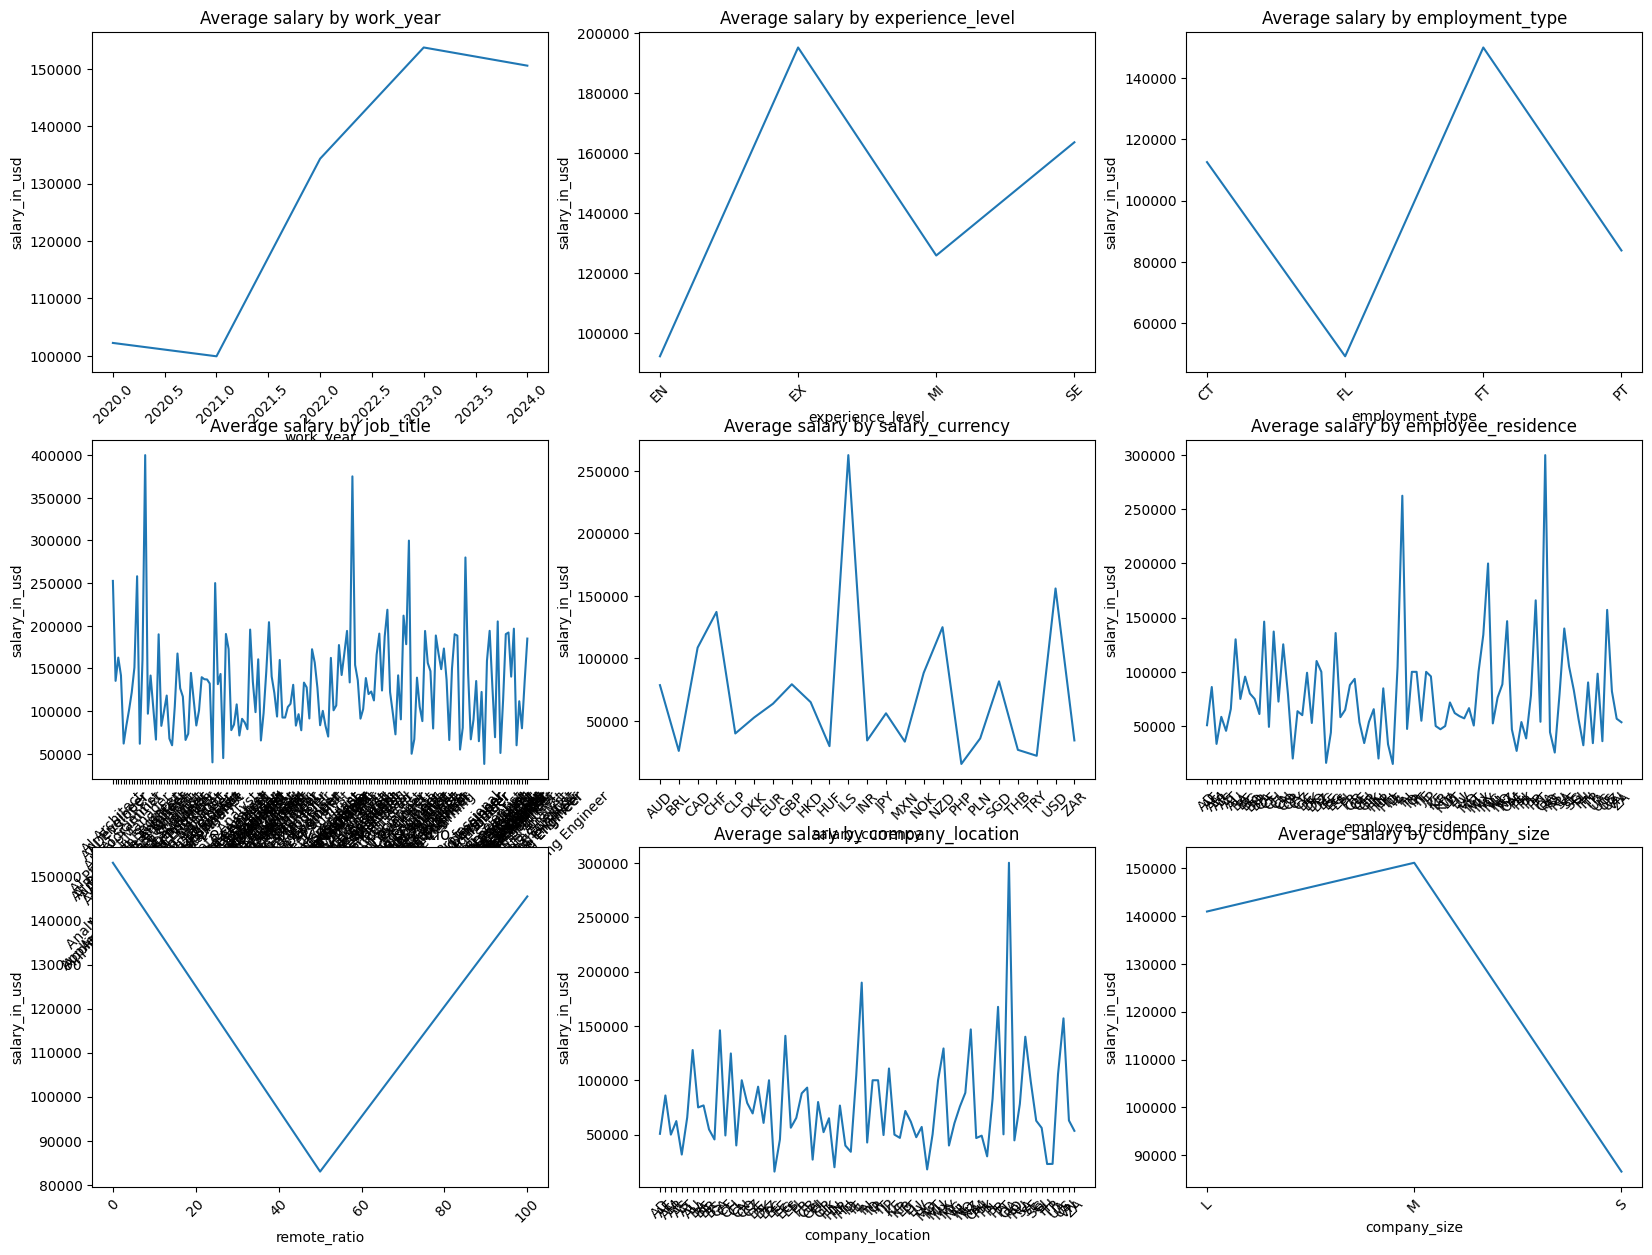

In [3]:
# Determine the number of columns to plot
num_columns = len(df.columns) - 1  # Exclude 'salary_in_usd'
num_rows = (num_columns + 2) // 3  # Adjust the number of rows based on the number of columns

fig, axes = plt.subplots(num_rows, 3, figsize=(20, num_rows * 5))
axes = axes.flatten()

# Track the index for the axes
ax_index = 0

for col in df.columns:
    if col != "salary_in_usd":
        # Calculate the average salary for each class of the feature
        avg_salary = df.groupby(col)["salary_in_usd"].mean().reset_index()
        
        # Plot the average salary for each class
        sns.lineplot(x=avg_salary[col], y=avg_salary["salary_in_usd"], ax=axes[ax_index])
        axes[ax_index].set_title(f'Average salary by {col}')
        axes[ax_index].set_xticklabels(axes[ax_index].get_xticklabels(), rotation=45)
        ax_index += 1

# Remove any unused subplots
for j in range(ax_index, len(axes)):
    fig.delaxes(axes[j])


if a variable as stronger results than the other this can show a correlation

Encode the string values

In [4]:
label_encoder = LabelEncoder()
columns = ["experience_level","employment_type","job_title","salary_currency","employee_residence","company_location","company_size"]
for col in columns:
    df[col] = label_encoder.fit_transform(df[col])

df


,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,3,2,2,21,202730,84,0,74,1
1,2024,3,2,2,21,92118,84,0,74,1
2,2024,3,2,57,21,130500,84,0,74,1
3,2024,3,2,57,21,96000,84,0,74,1
4,2024,3,2,120,21,190000,84,0,74,1
...,...,...,...,...,...,...,...,...,...,...
16529,2020,3,2,90,21,412000,84,100,74,0
16530,2021,2,2,140,21,151000,84,100,74,0
16531,2020,0,2,90,21,105000,84,100,74,2
16532,2020,0,0,28,21,100000,84,100,74,0


salary_in_usd distribution (detect outliers)

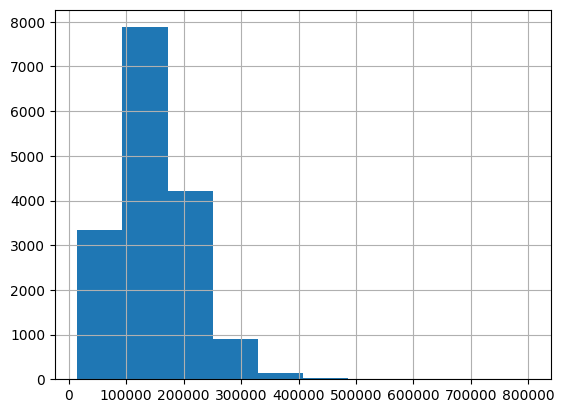

In [5]:
#print the salary_in_usd distribution
df["salary_in_usd"].hist()
plt.show()


remove outliers (value>350 000)

In [6]:
df = df[df["salary_in_usd"] < 350000]

correlation matrix

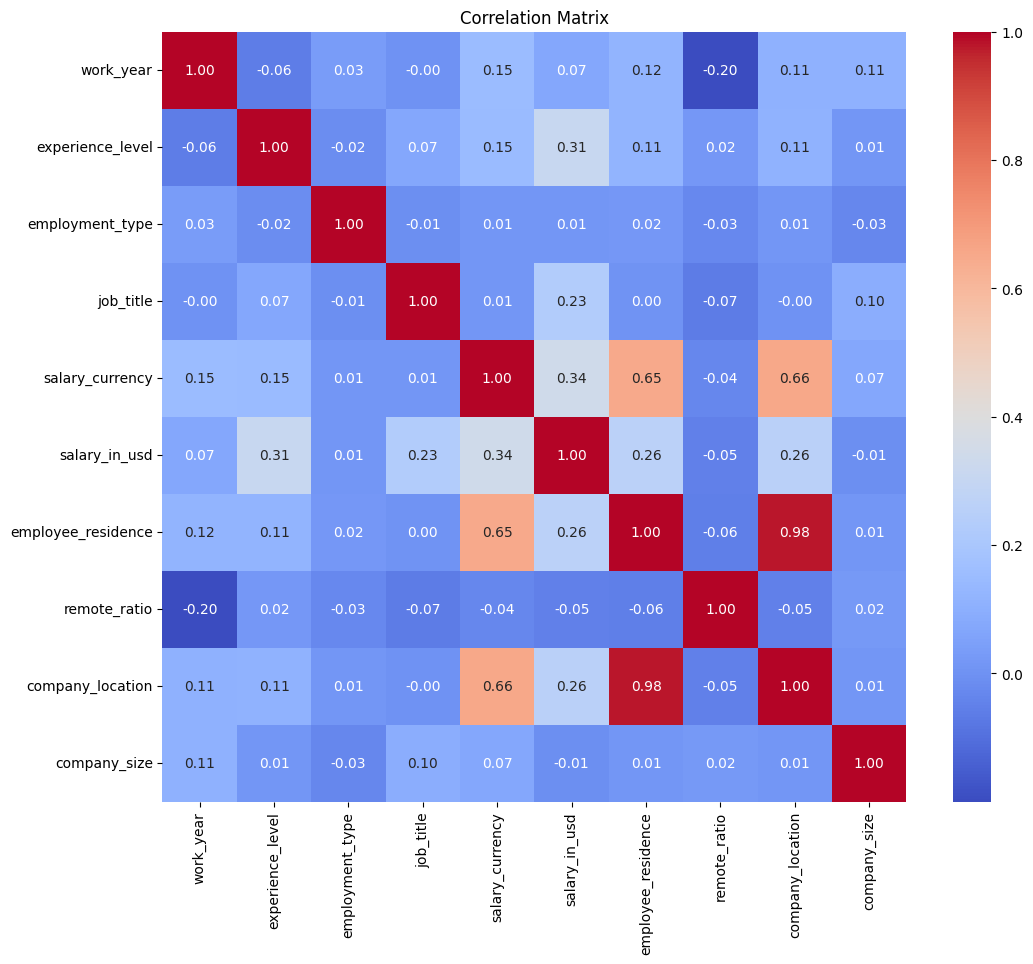

In [7]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)
plt.title('Correlation Matrix')
plt.show()

corrrelation with the output

In [8]:
corr_matrix["salary_in_usd"].sort_values(ascending=False)
corr_matrix["salary_in_usd"]

work_year             0.071161
experience_level      0.308572
employment_type       0.014386
job_title             0.231516
salary_currency       0.343236
salary_in_usd         1.000000
employee_residence    0.261597
remote_ratio         -0.051383
company_location      0.259504
company_size         -0.011301
Name: salary_in_usd, dtype: float64

## XGBoost use

split the data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("salary_in_usd", axis=1), df["salary_in_usd"], test_size=0.2, random_state=42)
y_test

9967     226600
2957      80000
14982     70186
5213     152375
2700     116600
          ...  
10036    225500
9715     115500
8622      67056
5419     155600
11414    250000
Name: salary_in_usd, Length: 3277, dtype: int64

Balance data (because as see before not well equilibrate)

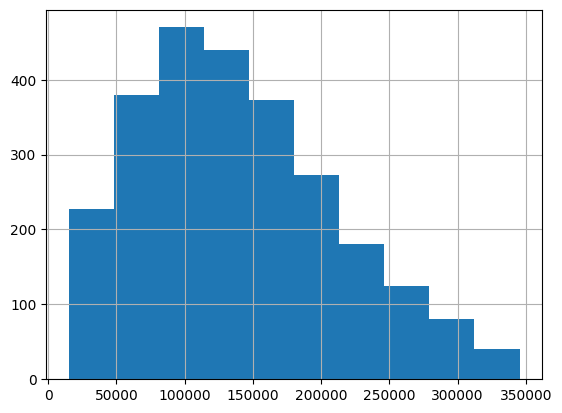

In [10]:
rus = RandomUnderSampler(random_state=42,sampling_strategy="majority")
X_train, y_train = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train)
#print the salary_in_usd distribution
y_train.hist()
plt.show()

Processing

100%|██████████| 200/200 [00:39<00:00,  5.07it/s]


{'subsample': 0.3, 'objective': 'reg:absoluteerror', 'min_child_weight': 10, 'max_depth': 25, 'lambda': 0, 'gamma': 5, 'eta': 0.5, 'alpha': 0}


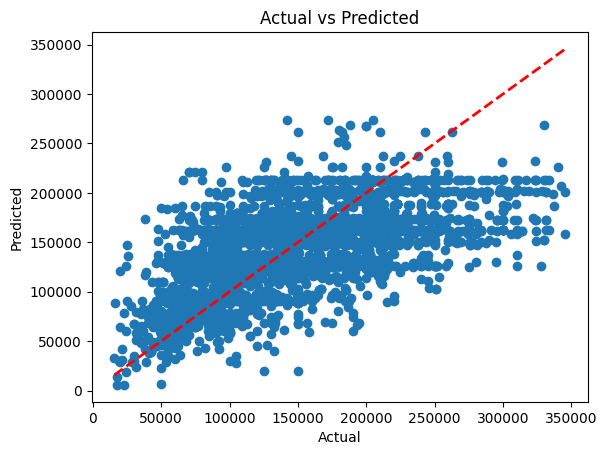

The max error is:  202500.0625
The mean absolute error is:  40295.39576558686
The r2 is:  0.3005867600440979
The root mean squared error is:  51726.2885602238


In [11]:
best_param,best_score = best_parameters_regression(X_train, y_train)
best_param

y_pred = predict_regression(X_train, y_train, X_test, best_param)
scores_regression(y_test, y_pred)